In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import multiprocessing
import os
import itertools
from collections import OrderedDict
import dask
from dask import compute, delayed
import statsmodels.tsa.stattools as ts
import math
import warnings
 
warnings.filterwarnings('ignore')

from helper import *
from stats import *
from product_info import *
from imp import reload

import helper
import stats

reload(helper)
reload(stats)

<module 'stats' from '/Users/sean/Desktop/Plan B/Quant/week2/stats.py'>

In [2]:
CORE_NUM = multiprocessing.cpu_count()
product_list  = ['bu', 'ru', 'v', 'pp', 'l', 'jd']

HEAD_PATH = '/Users/sean/Desktop/Plan B/Quant/week1'
DATA_PATH = HEAD_PATH + '/energy pkl tick/'

all_dates = list(map(lambda x: x,os.listdir(DATA_PATH + product_list[0])))
dates = []
for i in range(len(all_dates)):
    dates.append(int(all_dates[i][0:8]))
dates = np.sort(dates)
all_dates = []
for i in dates:
    all_dates.append(str(i) + '.pkl')
n_days = len(all_dates)

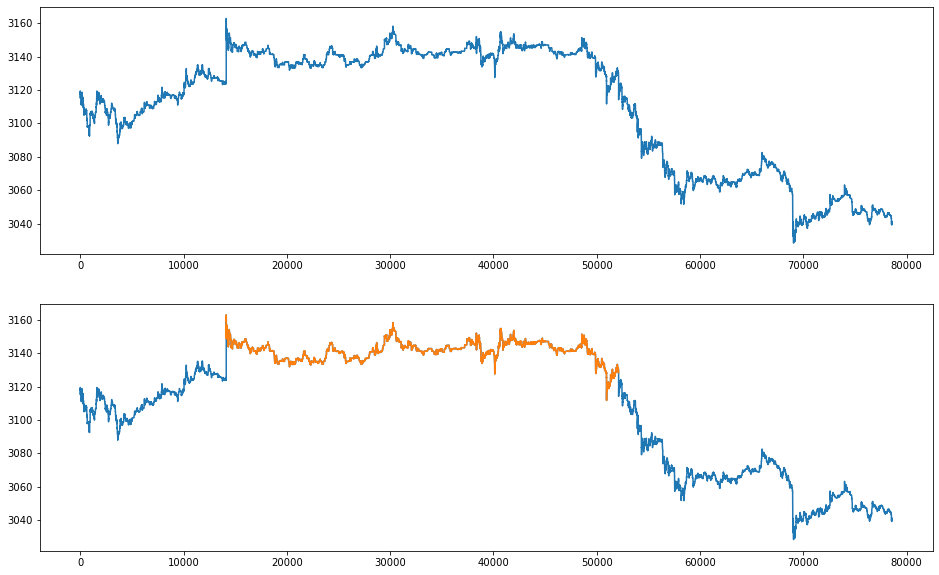

In [3]:
data = load(DATA_PATH+product_list[0]+"/"+"20190828.pkl")

# data.reset_index()[data.reset_index()['good']]['wpr']
plt.figure(1, figsize=(16, 10))
plt.subplot(2,1,1)
plt.plot(data.reset_index()["wpr"]);
plt.subplot(2,1,2)
plt.plot(data.reset_index()["wpr"]);
plt.plot(data.reset_index()[data.reset_index()["good"]]["wpr"]);

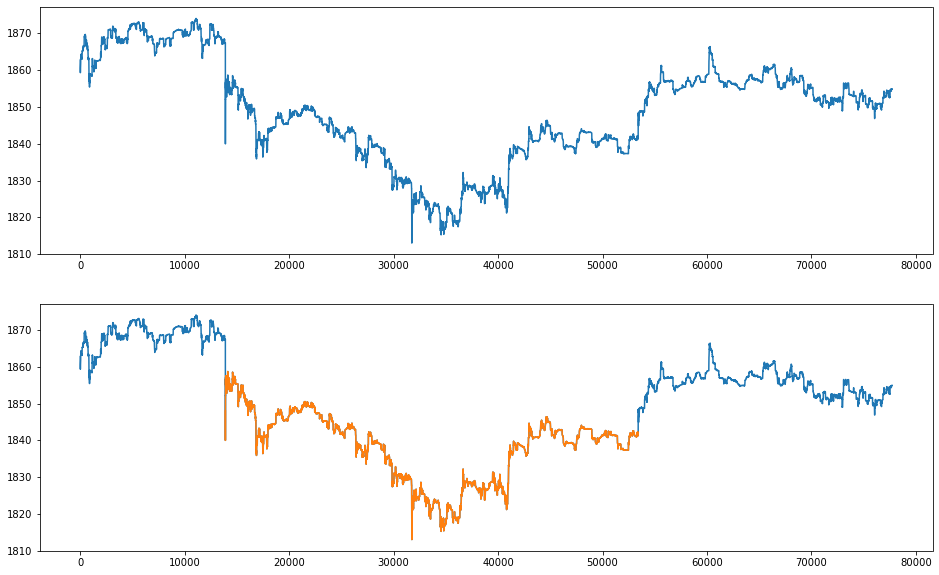

In [4]:
data = load(DATA_PATH+product_list[0]+"/"+all_dates[0])

plt.figure(1, figsize=(16, 10))
plt.subplot(2,1,1)
plt.plot(data["wpr"].values);
plt.subplot(2,1,2)
plt.plot(data.reset_index()["wpr"]);
# orange line for back-testing
plt.plot(data.reset_index()[data.reset_index()["good"]]["wpr"]);

- first signal buy/sell imbalance signal -> create a directory for signal -> create directory for products

In [5]:
period = 4096

for product in product_list:
    os.makedirs(HEAD_PATH + '/tmp pkl/' + product, exist_ok=True)
    
for product in product_list:
    os.makedirs(HEAD_PATH + '/tmp pkl/' + product + '/trade.imb.' + str(period), exist_ok=True)

def zero_divide(x, y):
    '''
    returns 0 if the numerator or denominator is 0
    '''
    with warnings.catch_warnings():
        warnings.simplefilter('ignore')
        res = np.divide(x, y)
    if hasattr(y, "__len__"):
        res[y==0] = 0
    elif y == 0:
        if hasattr(x, "__len__"):
            res = np.zeros(len(x))
        else:
            res = 0
    return res

def vanish_thre(x, thre):
    x[np.abs(x)>thre] = 0
    return x

def ewma(x, halflife, init=0, adjust=False):
    init_s = pd.Series(data=init)
    s = init_s.append(x)
    if adjust:
        xx = range(len(x))
        lamb=1 - 0.5**(1 / halflife)
        aa=1-np.power(1-lamb, xx)*(1-lamb)
        bb=s.ewm(halflife=halflife, adjust=False).mean().iloc[1:]
        return bb/aa
    else:
        return s.ewm(halflife=halflife, adjust=False).mean().iloc[1:]

class factor_total_trade_imb_period(factor_template):
    factor_name = 'total.trade.imb.period'
    
    params = OrderedDict([
        ("period", np.power(2, range(10,13)))
    ])
    
    def formula(self, data, period):
        return vanish_thre(zero_divide(ewma(data["buy.trade"]+data["buy2.trade"]-data["sell.trade"]-data["sell2.trade"], period, adjust=True), 
                           ewma(data["qty"], period, adjust=True)),1).values

In [6]:
SAVE_PATH = HEAD_PATH + '/factor'

def create_signal_path(signal_list, product, HEAD_PATH):
    keys = list(signal_list.params.keys())
    for cartesian in itertools.product(*signal_list.params.values()):
        signal_name = signal_list.factor_name
        for i in range(len(cartesian)):
            signal_name = signal_name.replace(keys[i], str(cartesian[i]))
        
        os.makedirs(HEAD_PATH+"/tmp pkl/"+product+"/"+signal_name, exist_ok=True)
        print(HEAD_PATH+"/tmp pkl/"+product+"/"+signal_name)

factor_1 = factor_total_trade_imb_period()
for product in product_list:
    create_signal_path(factor_1, product, SAVE_PATH);

/Users/sean/Desktop/Plan B/Quant/week1/factor/tmp pkl/bu/total.trade.imb.1024
/Users/sean/Desktop/Plan B/Quant/week1/factor/tmp pkl/bu/total.trade.imb.2048
/Users/sean/Desktop/Plan B/Quant/week1/factor/tmp pkl/bu/total.trade.imb.4096
/Users/sean/Desktop/Plan B/Quant/week1/factor/tmp pkl/ru/total.trade.imb.1024
/Users/sean/Desktop/Plan B/Quant/week1/factor/tmp pkl/ru/total.trade.imb.2048
/Users/sean/Desktop/Plan B/Quant/week1/factor/tmp pkl/ru/total.trade.imb.4096
/Users/sean/Desktop/Plan B/Quant/week1/factor/tmp pkl/v/total.trade.imb.1024
/Users/sean/Desktop/Plan B/Quant/week1/factor/tmp pkl/v/total.trade.imb.2048
/Users/sean/Desktop/Plan B/Quant/week1/factor/tmp pkl/v/total.trade.imb.4096
/Users/sean/Desktop/Plan B/Quant/week1/factor/tmp pkl/pp/total.trade.imb.1024
/Users/sean/Desktop/Plan B/Quant/week1/factor/tmp pkl/pp/total.trade.imb.2048
/Users/sean/Desktop/Plan B/Quant/week1/factor/tmp pkl/pp/total.trade.imb.4096
/Users/sean/Desktop/Plan B/Quant/week1/factor/tmp pkl/l/total.trade

In [7]:
%%time
for product in product_list:
    file_list = list(map(lambda x: DATA_PATH+product+"/"+x, os.listdir(DATA_PATH + product)))
    parLapply(CORE_NUM, file_list, build_composite_signal,signal_list=factor_1, product=product, HEAD_PATH=SAVE_PATH)
;   

CPU times: user 35.4 s, sys: 2.03 s, total: 37.5 s
Wall time: 4min 31s


'  '

In [8]:
SAVE_PATH

'/Users/sean/Desktop/Plan B/Quant/week1/factor'

In [9]:
to_choose = np.where(np.mod(range(n_days),10)==0)
signal_name = 'total.trade.imb.4096'
for product in product_list:
    all_signal = np.array([])
    for file in np.array(all_dates)[to_choose]:
        data = load(HEAD_PATH + '/energy pkl tick/' + product + '/' + file)
        S = load(SAVE_PATH + '/tmp pkl/' + product + '/' + signal_name + '/' + file)
        S = S[data['good']]
        all_signal = np.concatenate((all_signal, S), axis=0)
    sample_signal = all_signal[np.arange(1, len(all_signal) + 1) % period == 0]
    
    print('ADF Stationary Test')
    print('-------------------')
    adf_res = ts.adfuller(sample_signal, maxlag=int(pow(len(sample_signal)-1,(1/3))), regression='ct', autolag=None)
    print(product)
    if adf_res[1] < 0.05:
        print("STAT: ", adf_res[0], "STATIONARY")
    else:
        print("STAT: ", adf_res[0], "NON-STATIONARY")
    print('+++++++++++++++++++')
    kpss_res = ts.kpss(sample_signal, regression='c', lags=int(3*math.sqrt(len(sample_signal))/13))
    print(product)
    if kpss_res[1] > 0.05:
        print("STAT: ", adf_res[0], "STATIONARY")
    else:
        print("STAT: ", adf_res[0], "NON-STATIONARY")

ADF Stationary Test
-------------------
bu
STAT:  -9.466537913504512 STATIONARY
+++++++++++++++++++
bu
STAT:  -9.466537913504512 STATIONARY
ADF Stationary Test
-------------------
ru
STAT:  -8.541838519320471 STATIONARY
+++++++++++++++++++
ru
STAT:  -8.541838519320471 NON-STATIONARY
ADF Stationary Test
-------------------
v
STAT:  -7.064052327088618 STATIONARY
+++++++++++++++++++
v
STAT:  -7.064052327088618 STATIONARY
ADF Stationary Test
-------------------
pp
STAT:  -8.488528742974905 STATIONARY
+++++++++++++++++++
pp
STAT:  -8.488528742974905 STATIONARY
ADF Stationary Test
-------------------
l
STAT:  -6.72361060825407 STATIONARY
+++++++++++++++++++
l
STAT:  -6.72361060825407 STATIONARY
ADF Stationary Test
-------------------
jd
STAT:  -8.148375036932674 STATIONARY
+++++++++++++++++++
jd
STAT:  -8.148375036932674 STATIONARY


In [10]:
class factor_trade_imb_period(factor_template):
    factor_name = 'trade.imb.period'
    
    params = OrderedDict([
        ("period", np.array([1024, 2048, 4096]))
    ])
    
    def formula(self, data, period):
        return ewma(zero_divide(data['buy.trade'] - data['sell.trade'], data['buy.trade'] + data['sell.trade']), period, adjust=True).values

factor_2 = factor_trade_imb_period()
for product in product_list:
    create_signal_path(factor_2, product, SAVE_PATH);

/Users/sean/Desktop/Plan B/Quant/week1/factor/tmp pkl/bu/trade.imb.1024
/Users/sean/Desktop/Plan B/Quant/week1/factor/tmp pkl/bu/trade.imb.2048
/Users/sean/Desktop/Plan B/Quant/week1/factor/tmp pkl/bu/trade.imb.4096
/Users/sean/Desktop/Plan B/Quant/week1/factor/tmp pkl/ru/trade.imb.1024
/Users/sean/Desktop/Plan B/Quant/week1/factor/tmp pkl/ru/trade.imb.2048
/Users/sean/Desktop/Plan B/Quant/week1/factor/tmp pkl/ru/trade.imb.4096
/Users/sean/Desktop/Plan B/Quant/week1/factor/tmp pkl/v/trade.imb.1024
/Users/sean/Desktop/Plan B/Quant/week1/factor/tmp pkl/v/trade.imb.2048
/Users/sean/Desktop/Plan B/Quant/week1/factor/tmp pkl/v/trade.imb.4096
/Users/sean/Desktop/Plan B/Quant/week1/factor/tmp pkl/pp/trade.imb.1024
/Users/sean/Desktop/Plan B/Quant/week1/factor/tmp pkl/pp/trade.imb.2048
/Users/sean/Desktop/Plan B/Quant/week1/factor/tmp pkl/pp/trade.imb.4096
/Users/sean/Desktop/Plan B/Quant/week1/factor/tmp pkl/l/trade.imb.1024
/Users/sean/Desktop/Plan B/Quant/week1/factor/tmp pkl/l/trade.imb.20

In [11]:
DATA_PATH

'/Users/sean/Desktop/Plan B/Quant/week1/energy pkl tick/'

In [12]:
%%time
for product in product_list:
    file_list = list(map(lambda x: DATA_PATH + product + '/' + x, os.listdir(DATA_PATH + product)))
    parLapply(CORE_NUM, file_list, build_composite_signal, signal_list = factor_2, product=product, HEAD_PATH=SAVE_PATH);

CPU times: user 31.9 s, sys: 2.2 s, total: 34.1 s
Wall time: 4min 18s


In [13]:
to_choose = np.where(np.mod(range(n_days),10)==0)
signal_name = 'trade.imb.4096'
for product in product_list:
    all_signal = np.array([])
    for file in np.array(all_dates)[to_choose]:
        data = load(HEAD_PATH + '/energy pkl tick/' + product + '/' + file)
        S = load(SAVE_PATH + '/tmp pkl/' + product + '/' + signal_name + '/' + file)
        S = S[data['good']]
        all_signal = np.concatenate((all_signal, S), axis=0)
    sample_signal = all_signal[np.arange(1, len(all_signal) + 1) % period == 0]
    
    print('ADF Stationary Test')
    print('-------------------')
    adf_res = ts.adfuller(sample_signal, maxlag=int(pow(len(sample_signal)-1,(1/3))), regression='ct', autolag=None)
    print(product)
    if adf_res[1] < 0.05:
        print("STAT: ", adf_res[0], "STATIONARY")
    else:
        print("STAT: ", adf_res[0], "NON-STATIONARY")
    print('+++++++++++++++++++')
    kpss_res = ts.kpss(sample_signal, regression='c', lags=int(3*math.sqrt(len(sample_signal))/13))
    print(product)
    if kpss_res[1] > 0.05:
        print("STAT: ", adf_res[0], "STATIONARY")
    else:
        print("STAT: ", adf_res[0], "NON-STATIONARY")

ADF Stationary Test
-------------------
bu
STAT:  -8.058194265775155 STATIONARY
+++++++++++++++++++
bu
STAT:  -8.058194265775155 NON-STATIONARY
ADF Stationary Test
-------------------
ru
STAT:  -8.00047804253981 STATIONARY
+++++++++++++++++++
ru
STAT:  -8.00047804253981 STATIONARY
ADF Stationary Test
-------------------
v
STAT:  -6.444613914995491 STATIONARY
+++++++++++++++++++
v
STAT:  -6.444613914995491 STATIONARY
ADF Stationary Test
-------------------
pp
STAT:  -8.20384290465649 STATIONARY
+++++++++++++++++++
pp
STAT:  -8.20384290465649 STATIONARY
ADF Stationary Test
-------------------
l
STAT:  -7.588713631278218 STATIONARY
+++++++++++++++++++
l
STAT:  -7.588713631278218 STATIONARY
ADF Stationary Test
-------------------
jd
STAT:  -6.746478427741006 STATIONARY
+++++++++++++++++++
jd
STAT:  -6.746478427741006 STATIONARY


In [14]:
def get_atr(file, product, period_list, HEAD_PATH):
    data = load(file)
    
    for period in period_list:
        S = (data['max.' + str(period)] - data['min.' + str(period)])/data['wpr']
        save(S, HEAD_PATH + '/tmp pkl/' + product + '/atr.' + str(period) + '/' + file[-12:])

for product in product_list:
    for period in [1024, 2048, 4096]:
        os.makedirs(SAVE_PATH + '/tmp pkl/' + product + '/atr.' + str(period), exist_ok=True)

In [15]:
%%time
for product in product_list:
    file_list = list(map(lambda x: DATA_PATH + product + '/' + x, os.listdir(DATA_PATH + product)))
    parLapply(CORE_NUM, file_list, get_atr, product=product, period_list=np.array([1024,2048,4096]), HEAD_PATH=SAVE_PATH);

CPU times: user 7.79 s, sys: 2.05 s, total: 9.84 s
Wall time: 2min 39s


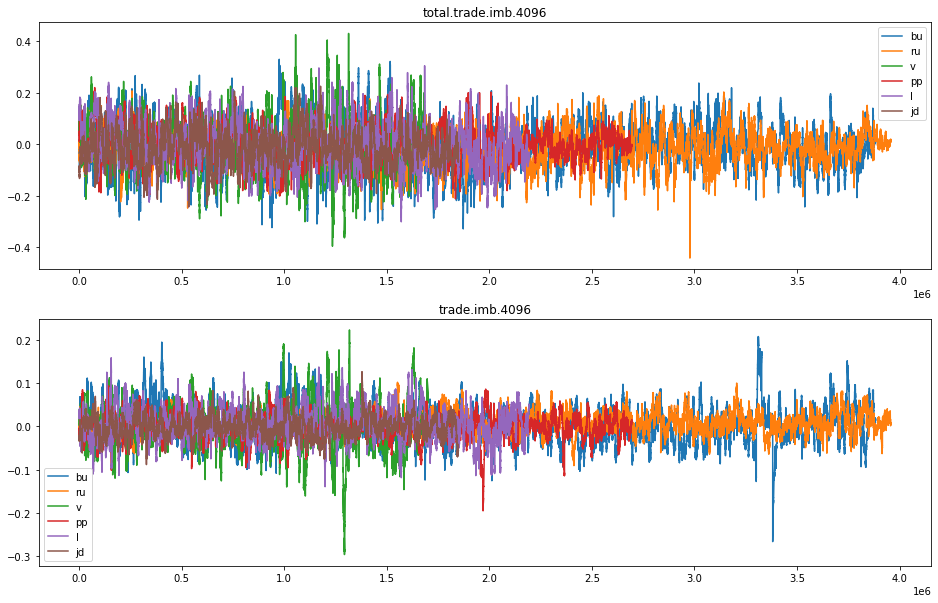

In [16]:
to_choose = (np.arange(n_days)+1) % 10 == 0
signal_name = 'total.trade.imb.4096'
all_product_signal = dict([])
for product in product_list:
    all_signal = np.array([])
    for file in np.array(all_dates)[to_choose]:
        data = load(HEAD_PATH + '/energy pkl tick/' + product + '/' + file)
        S = load(SAVE_PATH + '/tmp pkl/' + product + '/' + signal_name + '/' + file)
        S = S[data['good']]
        all_signal = np.concatenate((all_signal, S), axis=0)
    all_product_signal[product] = all_signal

plt.figure(1, figsize=(16,10))
plt.subplot(2,1,1)
# plot the 'total.trade.imb.4096' signal
for product in product_list:
    plt.plot(all_product_signal[product], label = product)
plt.title(signal_name)
plt.legend()

to_choose = (np.arange(n_days)+1) % 10 == 0
signal_name = 'trade.imb.4096'
all_product_signal = dict([])
for product in product_list:
    all_signal = np.array([])
    for file in np.array(all_dates)[to_choose]:
        data = load(HEAD_PATH + '/energy pkl tick/' + product + '/' + file)
        S = load(SAVE_PATH + '/tmp pkl/' + product + '/' + signal_name + '/' + file)
        S = S[data['good']]
        all_signal = np.concatenate((all_signal, S), axis=0)
    all_product_signal[product] = all_signal
plt.subplot(2,1,2)
# plot the 'trade.imb.4096' signal
for product in product_list:
    plt.plot(all_product_signal[product], label = product)
plt.title(signal_name)
plt.legend()

In [17]:
def sharpe(x):
    return zero_divide(np.mean(x)* np.sqrt(250), np.std(x, ddof=1))

def drawdown(x):
    y = np.cumsum(x)
    return np.max(y)-np.max(y[-1:])

def max_drawdown(x):
    y = np.cumsum(x)
    return np.max(np.maximum.accumulate(y)-y)

def get_hft_summary(result, thre_mat, n):
    all_result = pd.DataFrame(data={"daily.result" : result})
    daily_num = all_result['daily.result'].apply(lambda x: x['num'])
    daily_pnl = all_result['daily.result'].apply(lambda x: x['pnl'])
    daily_ret = all_result['daily.result'].apply(lambda x: x['ret'])
    total_num = daily_num.sum()
    if len(total_num) != len(thre_mat):
        raise selfException('Mismatch!')
    total_pnl = daily_pnl.sum()
    total_ret = daily_ret.sum()
    avg_pnl = zero_divide(total_pnl, total_num)
    avg_ret = zero_divide(total_ret, total_num)
    total_sharpe = sharpe(daily_pnl)
    total_drawdown = drawdown(daily_pnl)
    total_max_drawdown = max_drawdown(daily_pnl)
    sharpe_ret = sharpe(daily_ret)
    drawdown_ret = drawdown(daily_ret)
    max_drawdown_ret = max_drawdown(daily_ret)
    
    final_result = pd.DataFrame(data=OrderedDict([("open", thre_mat["open"]), ("close", thre_mat["close"]), ("num", total_num),
                                                 ("avg.pnl", avg_pnl), ("total.pnl", total_pnl), ("sharpe", total_sharpe), 
                                                 ("drawdown", total_drawdown), ("max.drawdown", total_max_drawdown), 
                                                  ("avg.ret", avg_ret), ("total.ret",total_ret), ("sharpe.ret", sharpe_ret),
                                                  ("drawdown.ret", drawdown_ret), ("max.drawdown.ret", max_drawdown_ret),
                                                 ("mar", total_pnl/total_max_drawdown), ("mar.ret", total_ret/max_drawdown_ret)]), 
                                index=thre_mat.index)
    return OrderedDict([("final.result", final_result), ("daily.num", daily_num), ("daily.pnl", daily_pnl), ("daily.ret", daily_ret)])

def get_signal_pnl(file, product, signal_name, thre_mat, reverse=1, tranct=1.1e-4, max_spread=0.61,
                   tranct_ratio=True, HEAD_PATH = '/Users/sean/Desktop/Plan B/Quant/week1', 
                   SAVE_PATH="/factor", atr_filter=0):
    
    # load data
    data = load(HEAD_PATH + '/energy pkl tick/' + product + '/' + file)
    S = load(HEAD_PATH + SAVE_PATH + '/tmp pkl/' + product + '/' + signal_name + '/' + file)
    pred = S * reverse
    pred = pred[data['good']]
    atr = load(HEAD_PATH + SAVE_PATH + '/tmp pkl/' + product + '/' + 'atr.4096' + '/' + file)
    atr = atr[data['good']].reset_index(drop=True)
    data = data[data['good']].reset_index(drop=True)
    
    # load signal
    ## we don't know the signal is positive correlated or negative correlated
    result = pd.DataFrame(data=OrderedDict([
        ("open", thre_mat['open'].values),
        ("close", thre_mat['close'].values),
        ("num", 0),
        ("avg.pnl", 0),
        ("pnl", 0),
        ("avg.ret", 0),
        ("ret", 0)
    ]), index=thre_mat.index)
    
    count = 0;
    cur_spread = data["ask"]-data["bid"]
    for thre in thre_mat.iterrows():
        count = count+1
        buy = pred>thre[1]["open"]
        sell = pred<-thre[1]["open"]
        signal = pd.Series(data=0, index=data.index)
        position = signal.copy()
        signal[buy] = 1
        signal[sell] = -1
        signal[atr<atr_filter]=0
        scratch = -thre[1]["close"]
        
        position_pos = pd.Series(data=np.nan, index=data.index)
        position_pos.iloc[0] = 0
        position_pos[(signal==1) & (data["next.ask"]>0) & (data["next.bid"]>0) & (cur_spread<max_spread)] = 1
        position_pos[(pred< -scratch) & (data["next.bid"]>0) & (cur_spread<max_spread)] = 0
        position_pos.ffill(inplace=True)
        pre_pos = position_pos.shift(1)
        
        notional_position_pos = pd.Series(data=0, index=data.index)
        notional_position_pos[position_pos==1] = 1
        notional_position_pos[(position_pos==1) & (pre_pos==1)] = np.nan
        notional_position_pos[(notional_position_pos==1)] = 1/data["next.ask"][(notional_position_pos==1)]
        notional_position_pos.ffill(inplace=True)
        
        position_neg = pd.Series(data=np.nan, index=data.index)
        position_neg.iloc[0] = 0
        position_neg[(signal==-1) & (data["next.ask"]>0) & (data["next.bid"]>0) & (cur_spread<max_spread)] = -1
        position_neg[(pred> scratch) & (data["next.ask"]>0) & (cur_spread<max_spread)] = 0
        position_neg.ffill(inplace=True)
        pre_neg = position_neg.shift(1)
        
        notional_position_neg = pd.Series(data=0, index=data.index)
        notional_position_neg[position_neg==-1] = -1
        notional_position_neg[(position_neg==-1) & (pre_neg==-1)] = np.nan
        notional_position_neg[(notional_position_neg==-1)] = -1/data["next.bid"][(notional_position_neg==-1)]
        notional_position_neg.ffill(inplace=True)
        
        position = position_pos + position_neg
        notional_position = notional_position_pos+notional_position_neg
        position.iloc[0] = 0
        position.iloc[-2:] = 0
        notional_position.iloc[0] = 0
        notional_position.iloc[-2:] = 0
        
        change_pos = position - position.shift(1)
        notional_change_pos = notional_position-notional_position.shift(1)
        change_pos.iloc[0] = 0
        notional_change_pos.iloc[0] = 0
        change_base = pd.Series(data=0, index=data.index)
        change_buy = change_pos>0
        change_sell = change_pos<0
        if (tranct_ratio):
            change_base[change_buy] = data["next.ask"][change_buy]*(1+tranct)
            change_base[change_sell] = data["next.bid"][change_sell]*(1-tranct)
        else:
            change_base[change_buy] = data["next.ask"][change_buy]+tranct
            change_base[change_sell] = data["next.bid"][change_sell]-tranct
        final_pnl = -sum(change_base*change_pos)
        ret = -sum(change_base*notional_change_pos)
        num = sum((position!=0) & (change_pos!=0))
        if num == 0:
            result.loc[thre[0], ("num", "avg.pnl", "pnl", "avg.ret", "ret")] = (0,0,0,0,0)
            return result
        else:
            avg_pnl = np.divide(final_pnl, num)
            avg_ret = np.divide(ret,num)
            result.loc[thre[0], ("num", "avg.pnl", "pnl", "avg.ret", "ret")] = (num, avg_pnl, final_pnl, avg_ret,ret)
    return result

In [18]:
%%time
signal_name = 'total.trade.imb.4096'
all_trade_stat = dict([])
open_list = np.arange(0.1, 0.4, 0.02)
thre_list = []
for cartesian in itertools.product(open_list, np.array([0.2, 0.4, 0.6, 0.8, 1.0])):
    thre_list.append((cartesian[0], -cartesian[0] * cartesian[1]))
thre_list = np.array(thre_list)
thre_mat = pd.DataFrame(data=OrderedDict([
    ("open", thre_list[:, 0]),
    ("close", thre_list[:, 1])
]))

for product in product_list:
    print(product)
    spread = product_info[product]['spread']
    tranct = product_info[product]['tranct']
    tranct_ratio = product_info[product]['tranct.ratio']
    with dask.config.set(scheduler='processes', num_workers=CORE_NUM):
        f_par = functools.partial(get_signal_pnl, product=product, signal_name=signal_name, 
                                  thre_mat=thre_mat, reverse=1, tranct=tranct, max_spread=spread*1.1,
                                  tranct_ratio=tranct_ratio, atr_filter=0.01)
        result = compute([delayed(f_par)(file) for file in all_dates])[0]
    trade_stat = get_hft_summary(result, thre_mat, n_days)
    all_trade_stat[product] = trade_stat
save(all_trade_stat, HEAD_PATH+"/"+"energy_trade_stat_total_trade_imb_4096.pkl")

bu
ru
v
pp
l
jd
CPU times: user 32.9 s, sys: 2.43 s, total: 35.4 s
Wall time: 11min 31s


In [19]:
%%time
signal_name = "trade.imb.4096"
all_trade_stat = dict([])
from collections import OrderedDict
import itertools
open_list = np.arange(0.06, 0.2, 0.02)
thre_list = []
for cartesian in itertools.product(open_list, np.array([0.2, 0.4, 0.6, 0.8, 1.0])):
    thre_list.append((cartesian[0], -cartesian[0] * cartesian[1]))
thre_list = np.array(thre_list)
thre_mat = pd.DataFrame(data=OrderedDict([("open", thre_list[:, 0]), ("close", thre_list[:, 1])]))
for product in product_list:
    print(product)
    spread = product_info[product]["spread"]
    tranct = product_info[product]["tranct"]
    tranct_ratio = product_info[product]["tranct.ratio"]
    with dask.config.set(scheduler='processes', num_workers=CORE_NUM):
        f_par = functools.partial(get_signal_pnl, product=product, signal_name=signal_name, thre_mat=thre_mat,
                                 reverse=1, tranct=tranct, max_spread=spread*1.1, tranct_ratio=tranct_ratio, atr_filter=0.01)
        result = compute([delayed(f_par)(file) for file in all_dates])[0]
    trade_stat = get_hft_summary(result, thre_mat, n_days)
    all_trade_stat[product] = trade_stat
save(all_trade_stat, HEAD_PATH+"/"+"energy_trade_stat_trade_imb_4096.pkl")

bu
ru
v
pp
l
jd
CPU times: user 33.1 s, sys: 2.32 s, total: 35.5 s
Wall time: 4min 31s


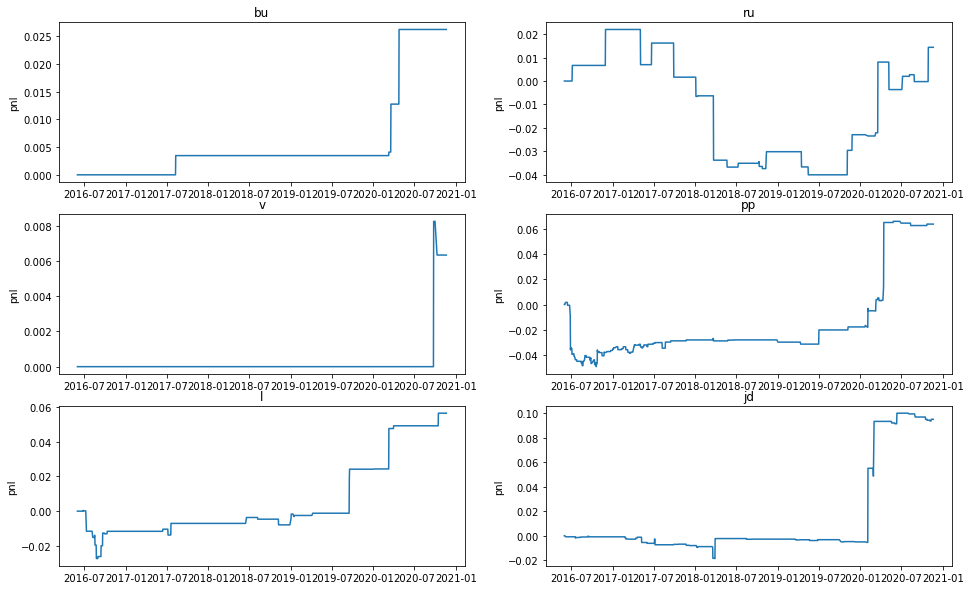

In [20]:
date_str = [n[0:8] for n in all_dates]
format_dates = np.array([pd.to_datetime(d) for d in date_str])

all_trade_stat = load(HEAD_PATH + '/' + 'energy_trade_stat_trade_imb_4096.pkl')
all_pnl = np.zeros([n_days, len(product_list)])
i = 0
for product in product_list:
    spread = product_info[product]['spread']
    trade_stat = all_trade_stat[product]
    good_strat = trade_stat['final.result']['avg.pnl']>1*spread
    if sum(good_strat) == 0:
        continue;
    good_pnl = trade_stat['daily.ret'].loc[:, good_strat].sum(axis=1)/sum(good_strat)
    all_pnl[:, i] = good_pnl
    i += 1
    plt.figure(1, figsize=(16,10))
    plt.subplot(3,2,i)
    plt.title("")
    plt.xlabel("")
    plt.ylabel("pnl")
    plt.title(product)
    plt.plot(format_dates, good_pnl.cumsum());

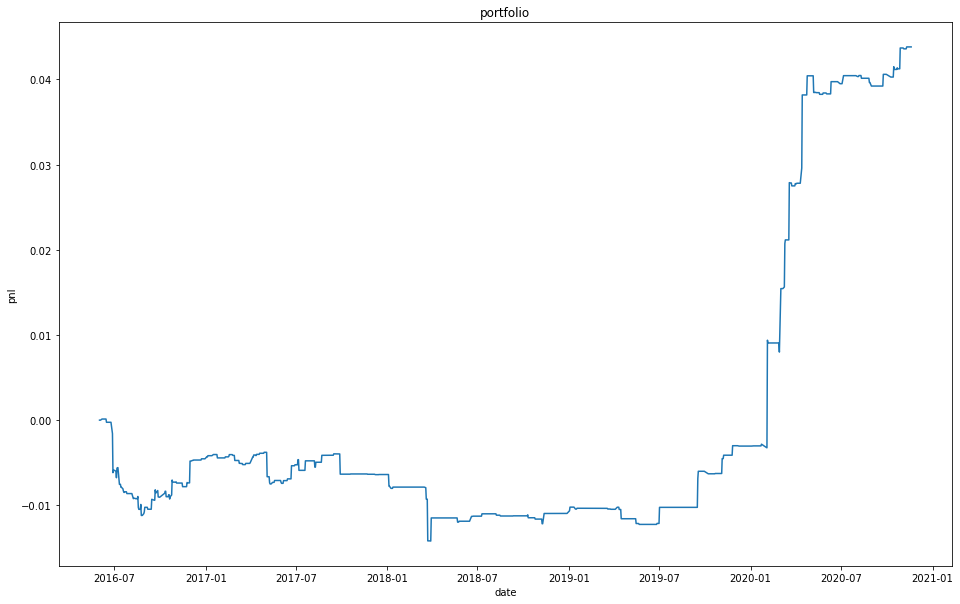

In [21]:
all_portfolio = np.array(np.mean(all_pnl[:,:i], axis=1))
plt.figure(1, figsize=(16, 10));
plt.title("");
plt.xlabel("date");
plt.ylabel("pnl");
plt.title("portfolio");
plt.plot(format_dates, all_portfolio.cumsum());

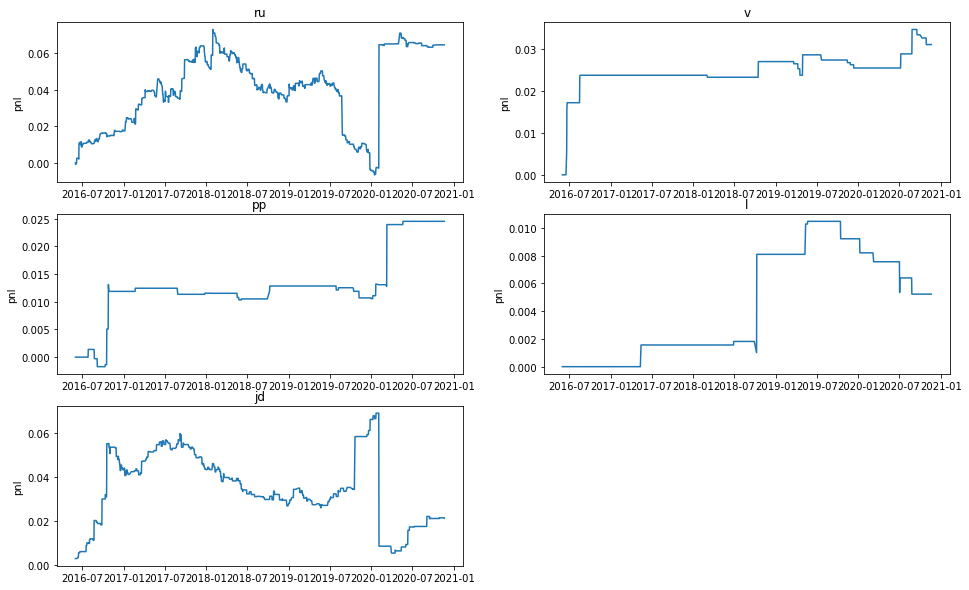

In [22]:
all_trade_stat = load(HEAD_PATH+"/"+"energy_trade_stat_total_trade_imb_4096.pkl")
all_pnl = np.zeros([n_days, len(product_list)])
i = 0
for product in product_list:
    spread = product_info[product]["spread"]
    trade_stat = all_trade_stat[product]
    good_strat = trade_stat["final.result"]["avg.pnl"]>1*spread
    if sum(good_strat)==0:
        continue;
    good_pnl = trade_stat["daily.ret"].loc[:, good_strat].sum(axis=1)/sum(good_strat)
    all_pnl[:,i] = good_pnl
    i = i+1
    plt.figure(1, figsize=(16,10))
    plt.subplot(3,2,i)
    plt.title("");
    plt.xlabel("");
    plt.ylabel("pnl");
    plt.title(product);
    plt.plot(format_dates, good_pnl.cumsum());

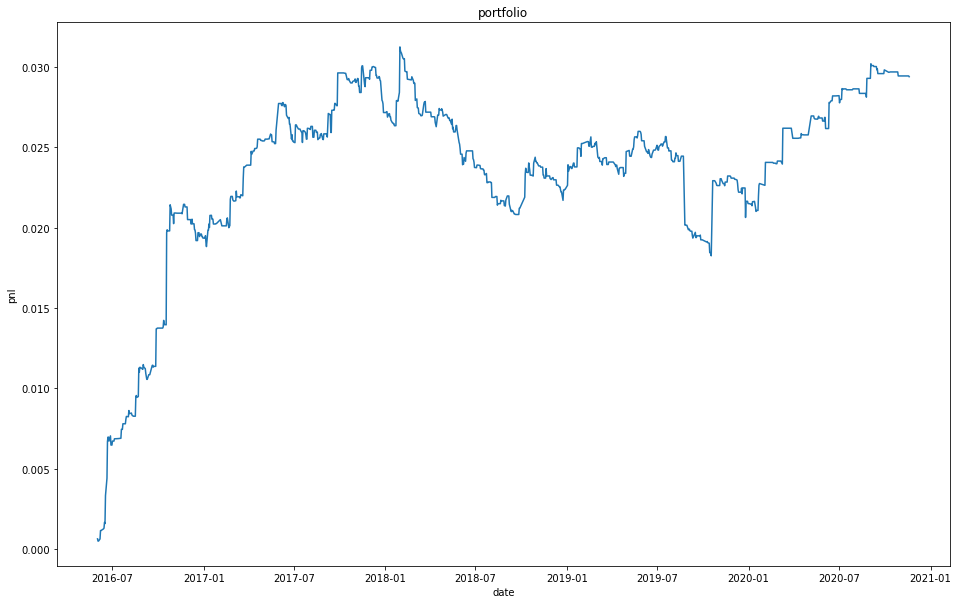

In [23]:
all_portfolio = np.array(np.mean(all_pnl[:,:i], axis=1))
plt.figure(1, figsize=(16, 10));
plt.title("");
plt.xlabel("date");
plt.ylabel("pnl");
plt.title("portfolio");
plt.plot(format_dates, all_portfolio.cumsum());

#### see in-sample and out-of-sample performance

In [32]:
# see in-sample and out-of-sample performance

train_sample = np.array(all_dates) < "201807"
test_sample = np.array(all_dates) > "201807"
print(sum(train_sample))
print(sum(test_sample))

507
581


In [25]:
%%time
signal_name = "trade.imb.4096"
train_trade_stat = dict([])
open_list = np.arange(0.06, 0.2, 0.002)
thre_list = []

for cartesian in itertools.product(open_list, np.array([0.2, 0.4, 0.6, 0.8, 1.0])):
    thre_list.append((cartesian[0], -cartesian[0] * cartesian[1]))
thre_list = np.array(thre_list)
thre_mat = pd.DataFrame(data=OrderedDict([("open", thre_list[:, 0]), ("close", thre_list[:, 1])]))

for product in product_list:
    spread = product_info[product]["spread"]
    print(product, spread)
    tranct = product_info[product]["tranct"]
    print(product, tranct)
    tranct_ratio = product_info[product]["tranct.ratio"]
    print(product, tranct_ratio)
    with dask.config.set(scheduler='processes', num_workers=CORE_NUM):
        f_par = functools.partial(get_signal_pnl, product=product, signal_name=signal_name, thre_mat=thre_mat,
                                 reverse=1, tranct=tranct, max_spread=spread*1.1, tranct_ratio=tranct_ratio, 
                                  atr_filter=0.01)
        result = compute([delayed(f_par)(file) for file in np.array(all_dates)[train_sample]])[0]
    trade_stat = get_hft_summary(result, thre_mat, sum(train_sample))
    train_trade_stat[product] = trade_stat
    

save(train_trade_stat, HEAD_PATH+"/energy_train_trade_stat.pkl")

bu 2
bu 0.000105
bu True
ru 5
ru 5e-05
ru True
v 5
v 0.44
v False
pp 1
pp 6.6e-05
pp True
l 5
l 0.44
l False
jd 2
jd 0.000165
jd True
CPU times: user 16 s, sys: 1.41 s, total: 17.4 s
Wall time: 7min 43s


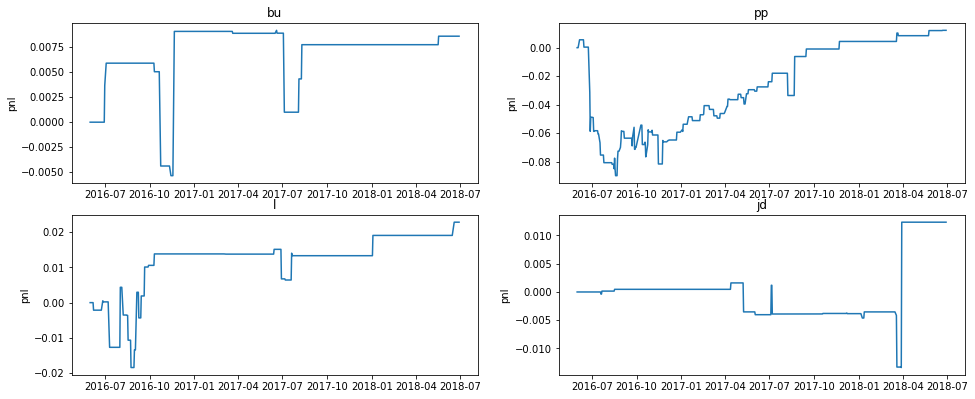

In [33]:
i = 0
train_trade_stat = load(HEAD_PATH + '/energy_train_trade_stat.pkl')
for product in product_list:
    spread = product_info[product]['spread']
    trade_stat = train_trade_stat[product]
    good_strat = (trade_stat["final.result"]["avg.pnl"]>1*spread) & (trade_stat["final.result"]["num"]>0)
    if sum(good_strat)==0:
        continue
    good_pnl = trade_stat["daily.ret"].loc[:, good_strat].sum(axis=1)/sum(good_strat)
    i = i+1
    plt.figure(1, figsize=(16,10))
    plt.subplot(3,2,i)
    plt.title("");
    plt.xlabel("");
    plt.ylabel("pnl");
    plt.title(product);
    plt.plot(format_dates[train_sample], good_pnl.cumsum());

In [34]:
%%time
signal_name = "trade.imb.4096"
test_trade_stat = dict([])
open_list = np.arange(0.06, 0.2, 0.002)
thre_list = []
for cartesian in itertools.product(open_list, np.array([0.2, 0.4, 0.6, 0.8, 1.0])):
    thre_list.append((cartesian[0], -cartesian[0] * cartesian[1]))
thre_list = np.array(thre_list)
thre_mat = pd.DataFrame(data=OrderedDict([("open", thre_list[:, 0]), ("close", thre_list[:, 1])]))
for product in product_list:
    spread = product_info[product]["spread"]
    tranct = product_info[product]["tranct"]
    tranct_ratio = product_info[product]["tranct.ratio"]
    with dask.config.set(scheduler='processes', num_workers=CORE_NUM):
        f_par = functools.partial(get_signal_pnl, product=product, signal_name=signal_name, thre_mat=thre_mat,
                                 reverse=1, tranct=tranct, max_spread=spread*1.1, tranct_ratio=tranct_ratio, atr_filter=0.01)
        result = compute([delayed(f_par)(file) for file in np.array(all_dates)[test_sample]])[0]
    trade_stat = get_hft_summary(result, thre_mat, sum(test_sample))
    test_trade_stat[product] = trade_stat

save(test_trade_stat, HEAD_PATH+"/energy_test_trade_stat.pkl")

CPU times: user 18.3 s, sys: 1.53 s, total: 19.9 s
Wall time: 7min 17s


bu train sharpe:  0.3127752245488273
bu test sharpe:  -0.21839077897416478
55
pp train sharpe:  0.11208505258222896
pp test sharpe:  0.9737063743072707
5
l train sharpe:  0.44767278220981477
l test sharpe:  0.9747100137738737
5
jd train sharpe:  0.30103922934981114
jd test sharpe:  0.7947991581939055
91


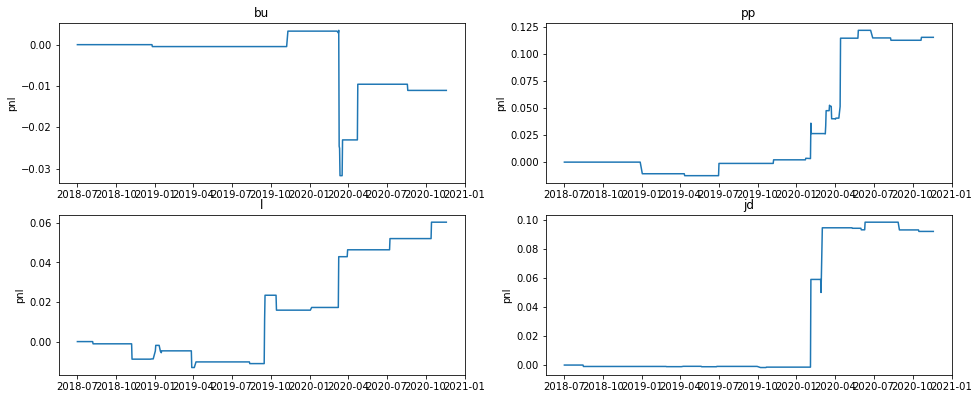

In [39]:
i = 0

train_trade_stat = load(HEAD_PATH+"/energy_train_trade_stat.pkl")
test_trade_stat = load(HEAD_PATH+"/energy_test_trade_stat.pkl")

test_all_pnl = np.zeros([sum(test_sample), len(product_list)])
train_all_pnl = np.zeros([sum(train_sample), len(product_list)])

for product in product_list:
    spread = product_info[product]['spread']
    trade_stat = train_trade_stat[product]
    good_strat = (trade_stat['final.result']['avg.pnl']>1*spread) & (trade_stat['final.result']['num']>0)
    
    if sum(good_strat)==0:
        continue
        
    train_pnl = trade_stat['daily.ret'].loc[:, good_strat].sum(axis=1)/sum(good_strat)
    trade_stat = test_trade_stat[product]
    test_pnl = trade_stat['daily.ret'].loc[:, good_strat].sum(axis=1)/sum(good_strat)
    
    print(product, "train sharpe: ", sharpe(train_pnl))
    print(product, "test sharpe: ", sharpe(test_pnl))
    print(sum(good_strat))
    
    test_all_pnl[:, i] = test_pnl
    train_all_pnl[:, i] = train_pnl
    i += 1
    plt.figure(1, figsize=(16, 10));
    plt.subplot(3,2,i);
    plt.title("");
    plt.xlabel("");
    plt.ylabel("pnl");
    plt.title(product);
    plt.plot(format_dates[test_sample], test_pnl.cumsum());



Portfolio Train Sharpe:  0.4437479732807236
Portfolio Test Sharpe:  1.2506760666942427


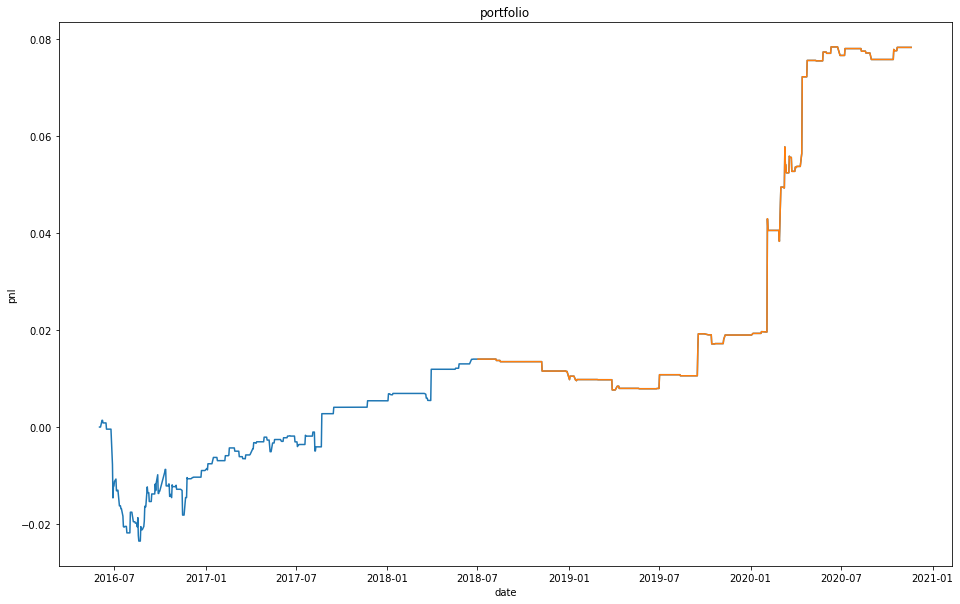

In [40]:
train_portfolio = np.array(np.mean(train_all_pnl[:,:i], axis=1))
test_portfolio = np.array(np.mean(test_all_pnl[:,:i], axis=1))
all_portfolio = np.append(train_portfolio, test_portfolio)
all_portfolio
plt.figure(1, figsize=(16, 10));
plt.title("");
plt.xlabel("date");
plt.ylabel("pnl");
plt.title("portfolio");
plt.plot(format_dates, all_portfolio.cumsum());
plt.plot(format_dates[test_sample], all_portfolio.cumsum()[test_sample]);
print("Portfolio Train Sharpe: ", sharpe(train_portfolio))
print("Portfolio Test Sharpe: ", sharpe(test_portfolio))


In [41]:
%%time
signal_name = "total.trade.imb.4096"
train_trade_stat = dict([])
open_list = np.arange(0.1, 0.4, 0.02)
thre_list = []
for cartesian in itertools.product(open_list, np.array([0.2, 0.4, 0.6, 0.8, 1.0])):
    thre_list.append((cartesian[0], -cartesian[0] * cartesian[1]))
thre_list = np.array(thre_list)
thre_mat = pd.DataFrame(data=OrderedDict([("open", thre_list[:, 0]), ("close", thre_list[:, 1])]))

for product in product_list:
    spread = product_info[product]["spread"]
    tranct = product_info[product]["tranct"]
    tranct_ratio = product_info[product]["tranct.ratio"]
    with dask.config.set(scheduler='processes', num_workers=CORE_NUM):
        f_par = functools.partial(get_signal_pnl, product=product, signal_name=signal_name, thre_mat=thre_mat,
                                 reverse=1, tranct=tranct, max_spread=spread*1.1, tranct_ratio=tranct_ratio, 
                                  atr_filter=0.01)
        result = compute([delayed(f_par)(file) for file in np.array(all_dates)[train_sample]])[0]
    trade_stat = get_hft_summary(result, thre_mat, sum(train_sample))
    train_trade_stat[product] = trade_stat

save(train_trade_stat, HEAD_PATH+"/energy_total_train_trade_stat.pkl")

CPU times: user 15.7 s, sys: 1.4 s, total: 17.1 s
Wall time: 6min 12s


In [42]:
%%time
signal_name = "total.trade.imb.4096"
test_trade_stat = dict([])
open_list = np.arange(0.1, 0.4, 0.02)
thre_list = []
for cartesian in itertools.product(open_list, np.array([0.2, 0.4, 0.6, 0.8, 1.0])):
    thre_list.append((cartesian[0], -cartesian[0] * cartesian[1]))
thre_list = np.array(thre_list)
thre_mat = pd.DataFrame(data=OrderedDict([("open", thre_list[:, 0]), ("close", thre_list[:, 1])]))

for product in product_list:
    spread = product_info[product]["spread"]
    tranct = product_info[product]["tranct"]
    tranct_ratio = product_info[product]["tranct.ratio"]
    with dask.config.set(scheduler='processes', num_workers=CORE_NUM):
        f_par = functools.partial(get_signal_pnl, product=product, signal_name=signal_name, thre_mat=thre_mat,
                                 reverse=1, tranct=tranct, max_spread=spread*1.1, tranct_ratio=tranct_ratio, 
                                  atr_filter=0.01)
        result = compute([delayed(f_par)(file) for file in np.array(all_dates)[test_sample]])[0]
    trade_stat = get_hft_summary(result, thre_mat, sum(train_sample))
    test_trade_stat[product] = trade_stat

save(test_trade_stat, HEAD_PATH+"/energy_total_test_trade_stat.pkl")

CPU times: user 18.1 s, sys: 1.53 s, total: 19.6 s
Wall time: 5min 21s


ru train sharpe:  0.625645931658779
ru test sharpe:  -0.18010244847671286
65
v train sharpe:  1.213882168918169
v test sharpe:  -0.4384287493292355
37
pp train sharpe:  0.8729048860763928
pp test sharpe:  0.8399626301265289
30
l train sharpe:  0.7565362235354831
l test sharpe:  -0.395850123342285
11
jd train sharpe:  0.9434672353436003
jd test sharpe:  -0.48609031463577307
25


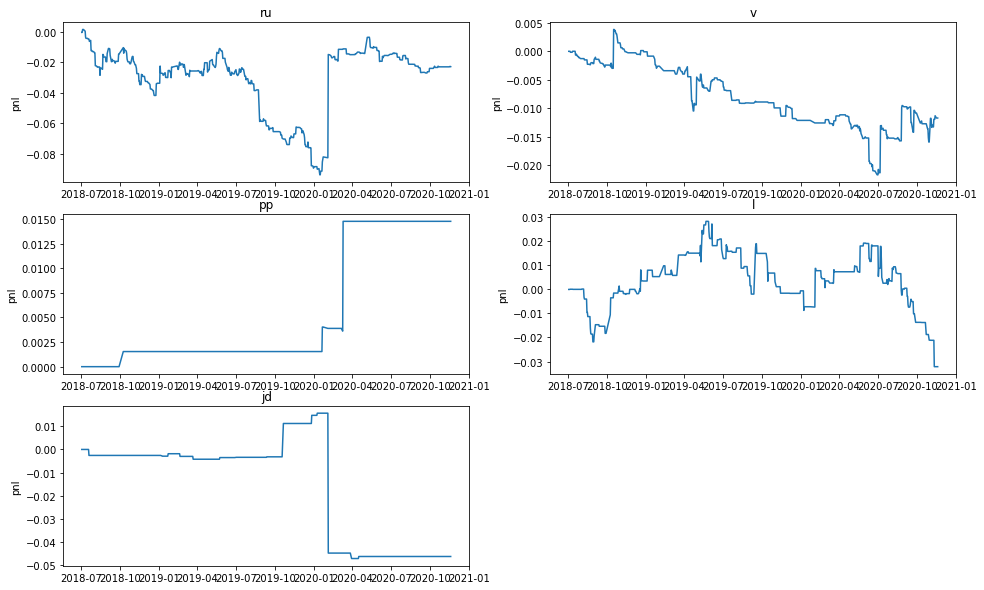

In [44]:
i = 0

train_trade_stat = load(HEAD_PATH+"/energy_total_train_trade_stat.pkl")
test_trade_stat = load(HEAD_PATH+"/energy_total_test_trade_stat.pkl")

test_all_pnl = np.zeros([sum(test_sample), len(product_list)])
train_all_pnl = np.zeros([sum(train_sample), len(product_list)])

for product in product_list:
    spread = product_info[product]['spread']
    trade_stat = train_trade_stat[product]
    good_strat = (trade_stat['final.result']['avg.pnl']>1*spread) & (trade_stat['final.result']['num']>0)
    
    if sum(good_strat)==0:
        continue
        
    train_pnl = trade_stat['daily.ret'].loc[:, good_strat].sum(axis=1)/sum(good_strat)
    trade_stat = test_trade_stat[product]
    test_pnl = trade_stat['daily.ret'].loc[:, good_strat].sum(axis=1)/sum(good_strat)
    
    print(product, "train sharpe: ", sharpe(train_pnl))
    print(product, "test sharpe: ", sharpe(test_pnl))
    print(sum(good_strat))
    
    test_all_pnl[:, i] = test_pnl
    train_all_pnl[:, i] = train_pnl
    i += 1
    plt.figure(1, figsize=(16, 10));
    plt.subplot(3,2,i);
    plt.title("");
    plt.xlabel("");
    plt.ylabel("pnl");
    plt.title(product);
    plt.plot(format_dates[test_sample], test_pnl.cumsum());

Portfolio Train Sharpe:  1.3661187260539636
Portfolio Test Sharpe:  -0.7751140364472335


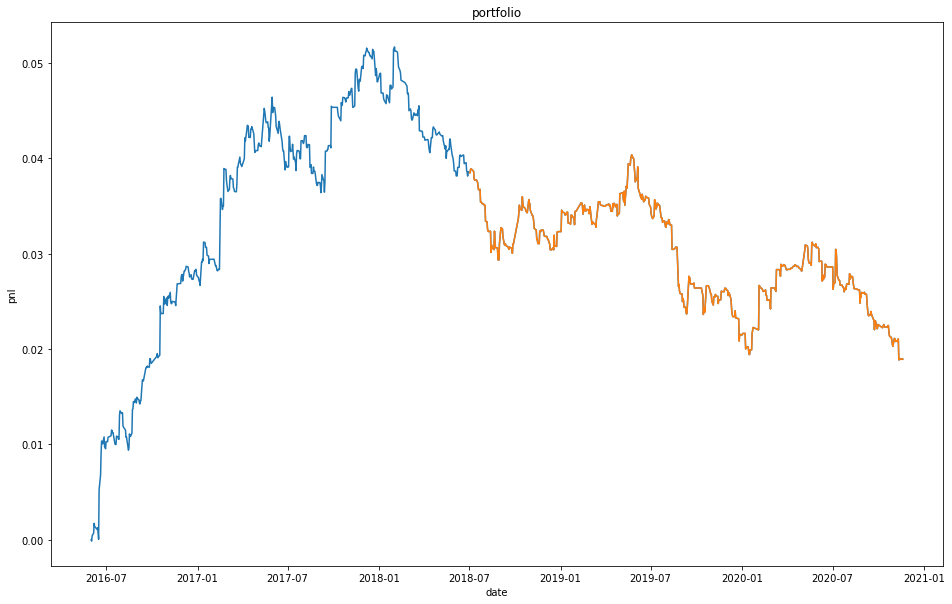

In [45]:

# See PnL for the portfolio
train_portfolio = np.array(np.mean(train_all_pnl[:,:i], axis=1))
test_portfolio = np.array(np.mean(test_all_pnl[:,:i], axis=1))
all_portfolio = np.append(train_portfolio, test_portfolio)
all_portfolio
plt.figure(1, figsize=(16, 10));
plt.title("");
plt.xlabel("date");
plt.ylabel("pnl");
plt.title("portfolio");
plt.plot(format_dates, all_portfolio.cumsum());
plt.plot(format_dates[test_sample], all_portfolio.cumsum()[test_sample]);
print("Portfolio Train Sharpe: ", sharpe(train_portfolio));
print("Portfolio Test Sharpe: ", sharpe(test_portfolio));